In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [55]:
df = pd.read_csv("bitcoin.csv")
df.head()

,timestamp,prices,market_caps,total_volumes
0,2013-04-28 00:00:00.000,135.30,1.500518e+09,0.0
1,2013-04-29 00:00:00.000,141.96,1.575032e+09,0.0
2,2013-04-30 00:00:00.000,135.30,1.501657e+09,0.0
3,2013-05-01 00:00:00.000,117.00,1.298952e+09,0.0
4,2013-05-02 00:00:00.000,103.43,1.148668e+09,0.0


(array([1.000e+00, 0.000e+00, 3.000e+00, 1.400e+01, 1.130e+02, 1.572e+03,
        1.974e+03, 1.350e+02, 1.400e+01, 1.000e+00]),
 array([-0.43371443, -0.36163308, -0.28955173, -0.21747037, -0.14538902,
        -0.07330767, -0.00122632,  0.07085503,  0.14293638,  0.21501774,
         0.28709909]),
 <BarContainer object of 10 artists>)

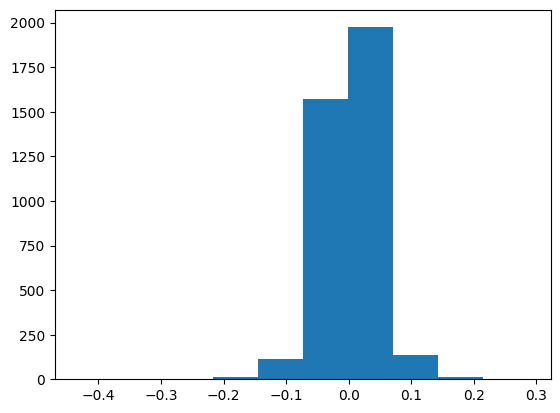

In [56]:
# 100x logged returns
df['log_returns'] = np.log(df['prices']) - np.log(df['prices']).shift(1)
df['log_returns_scaled'] = np.multiply(df['log_returns'], 100)
returns = pd.DataFrame(df['log_returns'].dropna())
plt.hist(returns['log_returns'])

In [64]:
data = df['log_returns'][1:] # drop the first value, which is NaN
data.head()

1    0.048051
2   -0.048051
3   -0.145321
4   -0.123279
5   -0.127926
Name: log_returns, dtype: float64

In [65]:
from sklearn.model_selection import train_test_split

# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 14  # You can adjust this
X, y = create_sequences(data, seq_length)



# Splitting the dataset into training and testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting to PyTorch tensors
X_train = Variable(torch.tensor(X_train).float())
y_train = Variable(torch.tensor(y_train).float())
X_test = Variable(torch.tensor(X_test).float())
y_test = Variable(torch.tensor(y_test).float())

X = Variable(torch.tensor(X).float())
y = Variable(torch.tensor(y).float())


In [69]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [72]:
epochs = 150  # You can adjust this

for i in range(epochs):
    for seq, labels in zip(X, y):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00000001
epoch:  26 loss: 0.00000001
epoch:  51 loss: 0.00000003
epoch:  76 loss: 0.00000000
epoch: 101 loss: 0.00000002
epoch: 126 loss: 0.00000004
epoch: 149 loss: 0.0000000039


In [77]:
forecasts = []
for x in X_test:
    forecasts.append(model(x))

In [78]:
forecasts

[tensor([-0.0433], grad_fn=<SelectBackward0>),
 tensor([-0.0580], grad_fn=<SelectBackward0>),
 tensor([0.0057], grad_fn=<SelectBackward0>),
 tensor([0.0355], grad_fn=<SelectBackward0>),
 tensor([-0.0008], grad_fn=<SelectBackward0>),
 tensor([0.0091], grad_fn=<SelectBackward0>),
 tensor([0.0357], grad_fn=<SelectBackward0>),
 tensor([0.0172], grad_fn=<SelectBackward0>),
 tensor([0.0120], grad_fn=<SelectBackward0>),
 tensor([0.0092], grad_fn=<SelectBackward0>),
 tensor([0.0088], grad_fn=<SelectBackward0>),
 tensor([0.0186], grad_fn=<SelectBackward0>),
 tensor([0.0134], grad_fn=<SelectBackward0>),
 tensor([0.0446], grad_fn=<SelectBackward0>),
 tensor([-0.0553], grad_fn=<SelectBackward0>),
 tensor([0.0404], grad_fn=<SelectBackward0>),
 tensor([-0.0130], grad_fn=<SelectBackward0>),
 tensor([0.1311], grad_fn=<SelectBackward0>),
 tensor([0.1959], grad_fn=<SelectBackward0>),
 tensor([0.0128], grad_fn=<SelectBackward0>),
 tensor([-0.0234], grad_fn=<SelectBackward0>),
 tensor([0.0373], grad_fn=<S